In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timesfm
import tqdm as notebook_tqdm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


c:\Users\z004s7fy\Desktop\Thesis\Thesis Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)].


In [ ]:
# 1. Build hyperparameters with context_len divisible by input_patch_len=32
hparams = timesfm.TimesFmHparams(
    backend="cpu",
    per_core_batch_size=1,
    context_len=96,           # must be a multiple of 32
    horizon_len=10,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
)

# 2. Point at the pretrained checkpoint
checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
)

# 3. Instantiate & load
tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timesfm                                # native library

# 1) Fetch last ~60 calendar days of AAPL daily closes
end_date   = pd.Timestamp.today().normalize()
start_date = end_date - pd.Timedelta(days=790)

series = (
    yf.download("AAPL", start=start_date, end=end_date,
                interval="1d", progress=False)["Close"]
      .dropna()
      .tz_localize(None)
)
print(start_date, end_date)
print(len(series))

2023-03-17 00:00:00 2025-05-15 00:00:00
542


In [18]:
# 2) Split into context (train) and 30-day horizon (test)
horizon = 30
train   = series.iloc[:-horizon]
test    = series.iloc[-horizon:]
print(series.iloc[:-horizon])
print(series.iloc[-horizon:])
print(train)
print(len(train), len(test))

Ticker            AAPL
Date                  
2023-03-17  153.251511
2023-03-20  155.624466
2023-03-21  157.483200
2023-03-22  156.049591
2023-03-23  157.137161
...                ...
2025-03-26  221.239868
2025-03-27  223.556839
2025-03-28  217.614624
2025-03-31  221.839096
2025-04-01  222.897705

[512 rows x 1 columns]
Ticker            AAPL
Date                  
2025-04-02  223.596786
2025-04-03  202.923904
2025-04-04  188.133301
2025-04-07  181.222366
2025-04-08  172.194199
2025-04-09  198.589584
2025-04-10  190.170624
2025-04-11  197.890488
2025-04-14  202.254776
2025-04-15  201.875275
2025-04-16  194.015579
2025-04-17  196.722031
2025-04-21  192.907028
2025-04-22  199.478424
2025-04-23  204.332062
2025-04-24  208.097107
2025-04-25  209.005920
2025-04-28  209.864792
2025-04-29  210.933395
2025-04-30  212.221710
2025-05-01  213.040634
2025-05-02  205.081070
2025-05-05  198.629532
2025-05-06  198.250015
2025-05-07  195.992981
2025-05-08  197.231369
2025-05-09  198.270004
2025-05-12

In [19]:

# 3) Build a TimesFM forecaster (200 M-param Torch checkpoint)
ctx_len = max(32, ((len(train) // 32) * 32))      # multiple of 32
print(ctx_len)

512


In [20]:
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",  # "gpu" if CUDA
        context_len=ctx_len,
        horizon_len=horizon,
        num_layers=20,
        model_dims=1280,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    ),
)

# 4) ZERO-SHOT FORECAST 30 steps ahead  ── FLATTEN the series! ──
input_series = train.astype("float32").to_numpy().ravel()
print(input_series.shape) 
print(input_series[:5])  
point_fcst, _ = tfm.forecast([input_series], freq=[0])  # 0 = daily
print(point_fcst.shape) 
print(point_fcst[:5])  
pred = pd.Series(point_fcst[0], index=test.index, name="TimesFM")


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


(512,)
[153.25151 155.62447 157.4832  156.04959 157.13716]
(1, 30)
[[225.68744 226.06026 225.99796 226.05688 226.77469 227.03484 227.90031
  228.15646 228.34352 227.80472 228.18771 227.88165 227.19955 226.74974
  226.6052  226.30476 226.42877 226.82599 226.83742 226.80307 226.90518
  226.53873 226.19669 226.13916 226.10678 225.38501 225.27399 225.34717
  225.71713 226.44232]]


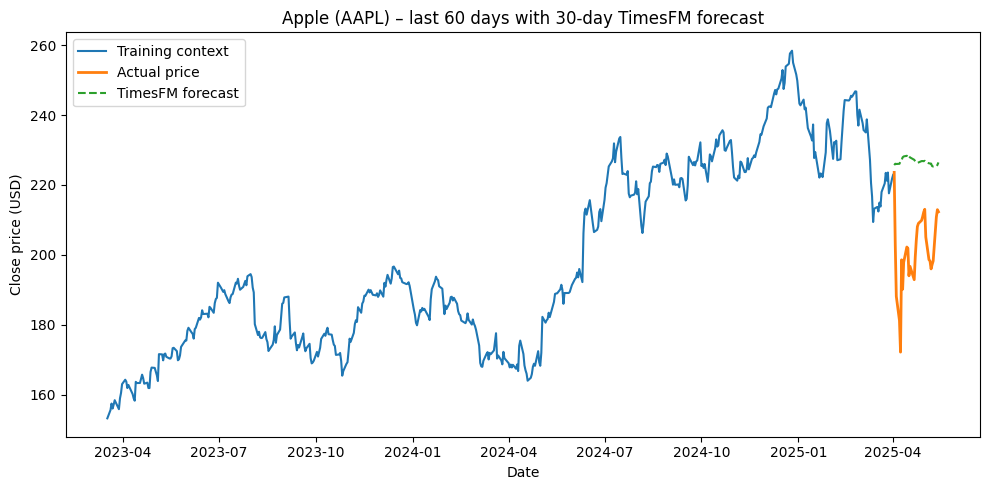

In [21]:

# 5) Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Training context")
plt.plot(test.index, test, label="Actual price", lw=2)
plt.plot(pred.index, pred, label="TimesFM forecast", ls="--")
plt.title("Apple (AAPL) – last 60 days with 30-day TimesFM forecast")
plt.xlabel("Date")
plt.ylabel("Close price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
print(train.shape, test.shape)
print(series.shape)

(244, 1) (20, 1)
(264, 1)


In [23]:
import yfinance as yf, pandas as pd, numpy as np, torch, math, os
from torch.utils.data import Dataset, DataLoader

# Pull ~10 years of daily closes
prices = (
    yf.download("AAPL", period="10y", interval="1d", progress=False)["Close"]
      .dropna()
      .tz_localize(None)
      .astype("float32")
)

CONTEXT, HORIZON = 512, 30   # model limits for TimesFM-1.0
STEP            = 30         # slide the window 30 days each time

class AppleWindowed(Dataset):
    def __init__(self, series):
        X, y = [], []
        for start in range(0, len(series) - CONTEXT - HORIZON, STEP):
            end_ctx   = start + CONTEXT
            end_hzn   = end_ctx + HORIZON
            X.append(series.iloc[start:end_ctx ].values)
            y.append(series.iloc[end_ctx:end_hzn].values)
        self.X = np.stack(X)              # (N, 512)
        self.y = np.stack(y)              # (N, 30)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.y[i])

ds   = AppleWindowed(prices)
dl   = DataLoader(ds, batch_size=16, shuffle=True, drop_last=True)
print(f"{len(ds):,d} training windows")

66 training windows


In [ ]:
# ---- build the foundation model ------------------------------------------------
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu" if torch.cuda.is_available() else "cpu",
        context_len=512,          # multiple of 32
        horizon_len=30,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    ),
)

# ---- plug in LoRA adapters (PEFT) ----------------------------------------------
from peft import LoraConfig, get_peft_model

lora_cfg = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"],  # names used in TimesFM attention
)

tfm = get_peft_model(tfm, lora_cfg)    #  <<<  NO “.model” here
tfm.print_trainable_parameters()       # sanity-check LoRA params only



SyntaxError: invalid syntax (3394551913.py, line 90)